Assignment 1: Sentiment Analysis

Dataset: IMDB 50K Movie Reviews

Goal: Compare 3 pretrained sentiment approaches:
- VADER 
- TextBlob 
- Transformer 

In [21]:
#Importing required libraries 
#Core
import pandas as pd
import numpy as np
import re

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Sentiment Models
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

#Transformer
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

#Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix

#Download VADER lexicon 
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sadafsarbazi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [22]:
#Load/Read dataset 
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
#View basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
#Check missing values
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [5]:
#Summary statistics
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
#Text length stats
df["text_length"] = df["review"].str.len()
df["text_length"].describe()

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: text_length, dtype: float64

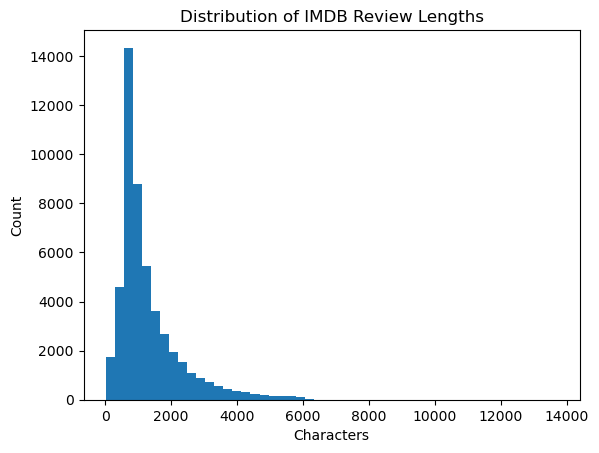

In [7]:
#Visualizing distribution of IMDB review lengths
plt.hist(df["text_length"], bins=50)
plt.title("Distribution of IMDB Review Lengths")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.show()

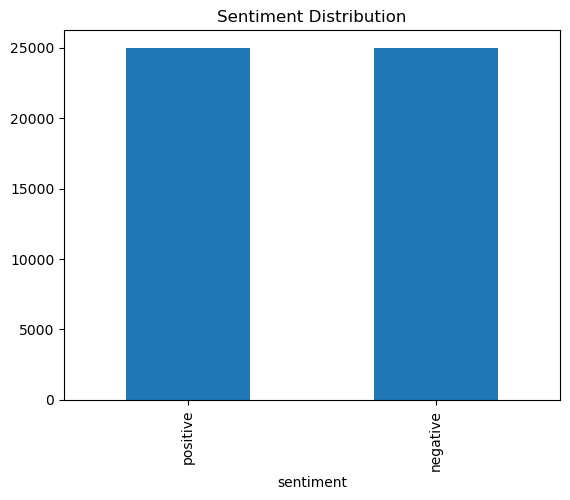

In [8]:
#Visualizing distribution of IMDB review sentiments
df["sentiment"].value_counts().plot(kind="bar", title="Sentiment Distribution")
plt.show()

In [9]:
#Sample reviews
df["review"].sample(5)

8132     If you had a mother that described you like th...
47203    The story idea is excellent. Unfortunately, th...
49581    I have become a big fan of the work of Barbet ...
48928    This film had my heart pounding. The acting wa...
1492     I found this movie to be extremely delightful....
Name: review, dtype: object

Initial Observations:
- Dataset contains 50,000 labeled movie reviews categorized as positive or negative
- Reviews vary significantly in length
- No major missing value issues were observed
- Reviews are written in English
- Special charachters, captilizations, contractions and puncutaions are present

In [10]:
#Contractions dictionary
contractions = {"don't": "do not","doesn't": "does not", "didn't": "did not", "can't": "cannot","won't": "will not",
    "i'm": "i am","you're": "you are","it's": "it is","that's": "that is","there's": "there is","isn't": "is not",
    "aren't": "are not","wasn't": "was not","weren't": "were not","haven't": "have not","hasn't": "has not","hadn't": "had not",
    "couldn't": "could not","shouldn't": "should not","wouldn't": "would not","n't": " not", "'re": " are","'s": " is","'m": " am",
    "'ll": " will","'ve": " have","'d": " would"}

In [11]:
#Cleaning
def clean_text(text):
    text = re.sub(r"<.*?>", " ", str(text)) #Remove HTML
    text = re.sub(r"http\S+|www\S+", " ", text) #Remove URLs
    text = text.lower()

    for c, full in contractions.items():  #Use contractions dict
        text = re.sub(r"\b" + re.escape(c) + r"\b", full, text)

    text = re.sub(r"[^a-z\s]", " ", text) #Keep letters/spaces only
    text = re.sub(r"\s+", " ", text).strip() #Normalize whitespace
    return text

#Apply cleaning
df["clean_text"] = df["review"].apply(clean_text)

In [12]:
#Spot-check validation
examples = ["<html>I LOVE this movie!!! 😍 http://bit.ly/xyz</html>","DON'T waste your time. It's not worth it.",
            "Rated 10/10.5 stars!!!"]

for i, text in enumerate(examples, 1):
    print(f"Example {i}")
    print("- Before:", text)
    print("- After:", clean_text(text))

Example 1
- Before: <html>I LOVE this movie!!! 😍 http://bit.ly/xyz</html>
- After: i love this movie
Example 2
- Before: DON'T waste your time. It's not worth it.
- After: do not waste your time it is not worth it
Example 3
- Before: Rated 10/10.5 stars!!!
- After: rated stars


Cleaning Decisions & Justifications:
- Example 1: Removed HTML, URL, emoji and lowercased text so only meaningful words remain
- Example 2: Lowercased and expanded contractions so negation is explicit and consistent
- Example 3: Removed numbers and punctuation to reduce noise and standardize the input

In [13]:
#Edge case testing
edge_cases = ["   ","<br /><div></div>","GreAt!","عالی بود","AMAZING!!!\" -- best??"]

for text in edge_cases:
    print("Before:", repr(text))
    print("After:", repr(clean_text(text)))

Before: '   '
After: ''
Before: '<br /><div></div>'
After: ''
Before: 'GreAt!'
After: 'great'
Before: 'عالی بود'
After: ''
Before: 'AMAZING!!!" -- best??'
After: 'amazing best'


In [14]:
#Basic feature engineering
df["word_count"] = df["clean_text"].apply(lambda x: len(x.split()))
df[["clean_text", "word_count"]].head()

,clean_text,word_count
0,one of the other reviewers has mentioned that ...,313
1,a wonderful little production the filming tech...,160
2,i thought this was a wonderful way to spend ti...,167
3,basically there is a family where a little boy...,133
4,petter mattei is love in the time of money is ...,228


In [15]:
#VADER
vader = SentimentIntensityAnalyzer()

def vader_features(text):
    scores = vader.polarity_scores(text)
    return pd.Series(scores)

df[["vader_negative", "vader_neutral", "vader_positive", "vader_compound"]] = df["clean_text"].apply(vader_features)

#Preview
df[["vader_negative", "vader_neutral", "vader_positive", "vader_compound"]].head()

,vader_negative,vader_neutral,vader_positive,vader_compound
0,0.192,0.747,0.061,-0.9944
1,0.053,0.763,0.184,0.9693
2,0.104,0.654,0.241,0.9812
3,0.135,0.783,0.082,-0.8858
4,0.052,0.788,0.160,0.9803


VADER Notes:
- Tokenization: VADER scores the text internally
- Features used/output: negative, neutral, positive (proportions) and compound(overall sentiment score in [-1, 1])  
- Vectorization: none required

In [16]:
#Textblob
def textblob_features(text):
    blob = TextBlob(text)
    return pd.Series({"tb_polarity": blob.sentiment.polarity,"tb_subjectivity": blob.sentiment.subjectivity})

df[["tb_polarity", "tb_subjectivity"]] = df["clean_text"].apply(textblob_features)

#Preview
df[["tb_polarity", "tb_subjectivity"]].head()

,tb_polarity,tb_subjectivity
0,0.060271,0.490952
1,0.108308,0.557525
2,0.356198,0.641648
3,0.001389,0.459259
4,0.214483,0.451359


TextBlob Notes:

- Tokenization: handled internally by TextBlob
- Features used/output: polarity in [-1, 1] and subjectivity in [0, 1]  
- Vectorization: none required

In [17]:
#Transformer (DistilBERT emotion model)
tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")
model = AutoModelForSequenceClassification.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion").eval()

#Emotion labels
labels = [model.config.id2label[i] for i in range(model.config.num_labels)]

def get_emotion_probs(texts, batch_size=32, max_length=256):
    texts = ["" if t is None else str(t) for t in texts]
    probs_all = []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
            probs = torch.softmax(model(**enc).logits, dim=1).numpy()
            probs_all.append(probs)

    return pd.DataFrame(np.vstack(probs_all), columns=labels)

#Quick check
demo = df["clean_text"].head(3).tolist()
demo_probs = get_emotion_probs(demo, batch_size=3)
demo_out = pd.concat([pd.Series(demo, name="clean_text"), demo_probs, demo_probs.idxmax(axis=1).rename("trans_emotion")], axis=1)
demo_out

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

,clean_text,sadness,joy,love,anger,fear,surprise,trans_emotion
0,one of the other reviewers has mentioned that ...,0.014772,0.037270,0.003349,0.762152,0.177726,0.004730,anger
1,a wonderful little production the filming tech...,0.000354,0.998501,0.000670,0.000203,0.000124,0.000149,joy
2,i thought this was a wonderful way to spend ti...,0.002601,0.975386,0.003980,0.006083,0.001060,0.010890,joy


Transformer Notes:
- Tokenization: uses subword tokenization (WordPiece) via AutoTokenizer  
- Vectorization: tokenizer produces numeric input_ids and attention_mask 
- features used/output: probabilities for 6 emotions of sadness, joy, love, anger, fear & surprise

In [18]:
#Edge case testing (same cleaning, different model processing)
edge_cases = {"Empty": "","Non-English": "これは日本語です", "Unusual characters": "!!! $$$ 😍🔥 @@@ not good ???"}

for name, raw in edge_cases.items():
    cleaned = clean_text(raw)
    print(f"\n{name}")
    print("Raw:", repr(raw))
    print("Cleaned:", repr(cleaned))

    #VADER
    print("VADER:", vader.polarity_scores(cleaned))

    #TextBlob
    if cleaned.strip():
        s = TextBlob(cleaned).sentiment
        print("TextBlob:", {"polarity": s.polarity, "subjectivity": s.subjectivity})
    else:
        print("TextBlob:", {"polarity": 0.0, "subjectivity": 0.0})

    #Transformer
    emo = get_emotion_probs([cleaned], batch_size=1).iloc[0]
    top_emotion = emo.idxmax()
    print("Transformer top emotion:", top_emotion)
    print("Transformer probs:", emo.to_dict())


Empty
Raw: ''
Cleaned: ''
VADER: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
TextBlob: {'polarity': 0.0, 'subjectivity': 0.0}
Transformer top emotion: anger
Transformer probs: {'sadness': 0.11096164584159851, 'joy': 0.20327690243721008, 'love': 0.020045187324285507, 'anger': 0.47305944561958313, 'fear': 0.17409685254096985, 'surprise': 0.018559925258159637}

Non-English
Raw: 'これは日本語です'
Cleaned: ''
VADER: {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
TextBlob: {'polarity': 0.0, 'subjectivity': 0.0}
Transformer top emotion: anger
Transformer probs: {'sadness': 0.11096164584159851, 'joy': 0.20327690243721008, 'love': 0.020045187324285507, 'anger': 0.47305944561958313, 'fear': 0.17409685254096985, 'surprise': 0.018559925258159637}

Unusual characters
Raw: '!!! $$$ 😍🔥 @@@ not good ???'
Cleaned: 'not good'
VADER: {'neg': 0.706, 'neu': 0.294, 'pos': 0.0, 'compound': -0.3412}
TextBlob: {'polarity': -0.35, 'subjectivity': 0.6000000000000001}
Transformer top emotion: joy
Trans

Edge Case Notes:
- Empty text becomes an empty string after cleaning and returns neutral/default-like outputs
- Non-English inputs still produce outputs, but may be unreliable because the tools/models are trained mainly on English
- Unusual characters are removed by cleaning; predictions are based on remaining words (e.g., “not good”)

In [20]:
#Make predictions
def label_vader(compound):
    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    return "neutral"

def label_textblob(polarity):
    if polarity >= 0.1:
        return "positive"
    elif polarity <= -0.1:
        return "negative"
    return "neutral"

def top_emotion_from_probs(prob_series):
    return prob_series.idxmax()

def label_from_emotion(emotion):
    e = str(emotion).lower()
    if e in ["joy", "love"]:
        return "positive"
    if e in ["sadness", "anger", "fear"]:
        return "negative"
    return "neutral"  # surprise is ambiguous

In [21]:
df["pred_vader"] = df["vader_compound"].apply(label_vader)
df["pred_textblob"] = df["tb_polarity"].apply(label_textblob)
df[["pred_vader", "pred_textblob"]].head()

,pred_vader,pred_textblob
0,negative,neutral
1,positive,positive
2,positive,positive
3,negative,neutral
4,positive,positive


In [22]:
#Create sample of 100 for manual labeling + model comparison
sample_100 = df.sample(100, random_state=42).copy().reset_index(drop=True)

#VADER + TextBlob predictions for sample
sample_100["pred_vader"] = sample_100["vader_compound"].apply(label_vader)
sample_100["pred_textblob"] = sample_100["tb_polarity"].apply(label_textblob)

#Transformer predictions for sample
emo_100 = get_emotion_probs(sample_100["clean_text"].tolist(), batch_size=32)
sample_100[labels] = emo_100
sample_100["trans_emotion"] = emo_100.idxmax(axis=1)
sample_100["pred_transformer"] = sample_100["trans_emotion"].apply(label_from_emotion)

#Export for manual labeling (you will add column y_true)
to_label = sample_100[["review", "clean_text", "pred_vader", "pred_textblob","trans_emotion", "pred_transformer"]].copy()
to_label.to_csv("sample_100_for_labeling.csv", index=False)

to_label.head()

,review,clean_text,pred_vader,pred_textblob,trans_emotion,pred_transformer
0,I really liked this Summerslam due to the look...,i really liked this summerslam due to the look...,positive,neutral,sadness,negative
1,Not many television shows appeal to quite as m...,not many television shows appeal to quite as m...,positive,positive,joy,positive
2,The film quickly gets to a major chase scene w...,the film quickly gets to a major chase scene w...,positive,positive,joy,positive
3,Jane Austen would definitely approve of this o...,jane austen would definitely approve of this o...,positive,positive,joy,positive
4,Expectations were somewhat high for me when I ...,expectations were somewhat high for me when i ...,negative,neutral,anger,negative


In [23]:
#Load labeled csv
labeled = pd.read_csv("sample_100_for_labeling.csv")

In [24]:
#Accuracy
def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

acc_v = accuracy(labeled["y_true"], labeled["pred_vader"])
acc_t = accuracy(labeled["y_true"], labeled["pred_textblob"])
acc_tr = accuracy(labeled["y_true"], labeled["pred_transformer"])

print("Accuracy on 100 manually labeled reviews")
print("VADER:", acc_v)
print("TextBlob:", acc_t)
print("Transformer:", acc_tr)

Accuracy on 100 manually labeled reviews
VADER: 0.56
TextBlob: 0.47
Transformer: 0.49


In [25]:
#Confusion Matrix
def confusion_matrix_df(y_true, y_pred, labels=("negative","neutral","positive")):
    cm = pd.DataFrame(0, index=labels, columns=labels)
    for t, p in zip(y_true, y_pred):
        if t in labels and p in labels:
            cm.loc[t, p] += 1
    return cm

labels3 = ("negative","neutral","positive")

cm_v = confusion_matrix_df(labeled["y_true"], labeled["pred_vader"], labels3)
cm_t = confusion_matrix_df(labeled["y_true"], labeled["pred_textblob"], labels3)
cm_tr = confusion_matrix_df(labeled["y_true"], labeled["pred_transformer"], labels3)

#Confusion Matrix for VADER
print("VADER Confusion Matrix")
cm_v

VADER Confusion Matrix


,negative,neutral,positive
negative,22,0,18
neutral,10,0,13
positive,3,0,34


In [26]:
#Confusion Matrix for TextBlob
print("TextBlob Confusion Matrix")
cm_t

TextBlob Confusion Matrix


,negative,neutral,positive
negative,8,25,7
neutral,1,12,10
positive,0,10,27


In [27]:
#Confusion Matrix for Transformer
print("Transformer Confusion Matrix")
cm_tr

Transformer Confusion Matrix


,negative,neutral,positive
negative,25,4,11
neutral,8,1,14
positive,11,3,23


In [37]:
#Success & failure examples
def show_examples(df_in, pred_col, correct=True, n=3, seed=0):
    mask = (df_in["y_true"] == df_in[pred_col]) if correct else (df_in["y_true"] != df_in[pred_col])
    subset = df_in[mask].copy()
    if len(subset) == 0:
        return subset
    return subset.sample(min(n, len(subset)), random_state=seed)[["review","y_true", pred_col]]

print("VADER successes:")
display(show_examples(labeled, "pred_vader", correct=True, n=3, seed=1))

print("VADER failures:")
display(show_examples(labeled, "pred_vader", correct=False, n=3, seed=2))

print("TextBlob successes:")
display(show_examples(labeled, "pred_textblob", correct=True, n=3, seed=3))

print("TextBlob failures:")
display(show_examples(labeled, "pred_textblob", correct=False, n=3, seed=4))

print("Transformer successes:")
display(show_examples(labeled, "pred_transformer", correct=True, n=3, seed=5))

print("Transformer failures:")
display(show_examples(labeled, "pred_transformer", correct=False, n=3, seed=6))

#Increasing display size
pd.set_option("display.max_colwidth", None)
pd.set_option("display.expand_frame_repr", False)

VADER successes:


,review,y_true,pred_vader
76,May Contain Spoilers.<br /><br />An innocent trailer park or maybe 'Compton' LA white kid witnesses a terrible childhood tragedy relating to drugs and violence. An unprofessional but dedicated police partners try to take down a 'sophisticated' high end club drug ring only to be fired and chewed out by the the drug lords high priced attorneys. The plot thickens as more people come back to seek vengeance and justice with a predictable ending. The only memorable part was a walk-on by Ron Jeremy.<br /><br />If I was in a movie theater I would have asked for a refund. I feel sorry for the poor actors in this movie. It was just awful and painful to watch. The worst part was the cinematography were the director kept flashing back within the same scene so the sound would not quite match. And NO it was not a codec nor DVD problem but an intentional technique. Ughh. Two Stars.,negative,negative
3,"Jane Austen would definitely approve of this one!<br /><br />Gwyneth Paltrow does an awesome job capturing the attitude of Emma. She is funny without being excessively silly, yet elegant. She puts on a very convincing British accent (not being British myself, maybe I'm not the best judge, but she fooled me...she was also excellent in ""Sliding Doors""...I sometimes forget she's American ~!). <br /><br />Also brilliant are Jeremy Northam and Sophie Thompson and Phyllida Law (Emma Thompson's sister and mother) as the Bates women. They nearly steal the show...and Ms. Law doesn't even have any lines!<br /><br />Highly recommended.",positive,positive
80,"It is quite rare that a movie comes along that is so useless, that I with IMDb allowed the use of negative scores. In fact, I reflect back upon this movie and I truly cannot think of a movie that had so little going for it. Acting: Your Kidding right. Direction: No. A plot: No. This movie has nothing going for it if you take it as a serious movie, this is often the case with movies of this genre, but most movies of this nature can be watch as if they are a comedy and you can laugh at how pathetic the characters and situations are and almost get your times worth. This movie is so empty, that it cannot even suit that purpose. I have to give this a -1/10, three points lower then any other movie I have ever rated. I truly feel that the staff involved in this movie should pay me for the 83 minutes I spent watching it. I do not really have the words to describe how bad this is. No one should ever watch this for any reason again.",negative,negative


VADER failures:


,review,y_true,pred_vader
72,"Spinal Tap was funny because if you knew a little about heavy metal, you saw in-jokes all over the place. If you know anything about porn, this mock documentary will leave you cold. Everything in it rings false.<br /><br />Spinal Tap was funny because it took a familiar world and pushed it over the top. This film is decidedly not funny because it paints a picture of how porn is made that bears no relationship to the real world.<br /><br />The acting here is uniformly awful, but that would not matter much if the core idea of the movie were good. But it's not.",negative,positive
79,"Again, we're getting a melange of themes well covered by so many previous films. The good and the bad son story, courtesy East of Eden. The American marine hero story, who doesn't consider himself to be one due to what he knows. And the grieving wife potentially falling in love with another man story.<br /><br />The mere fact of those stories being that ubiquitous isn't so much of a problem though. Because theoretically they could still be better presented and dealt with each time around. No luck this time though, as all three of those threads ultimately fall flat all the same.<br /><br />As the bad son never really gets to talk to his father, so that conflict is never resolved properly. Apart from the father kind of starting to appreciate the bad son thanks to the latter renovating the kitchen of the grieving wife. Now, how satisfying is that.<br /><br />Next, the surprisingly homecoming marine suspecting his wife of unfaithfulness conflict never gets resolved. Because he never really talks to the man under suspicion, namely his own brother. So once more we're handed a loose end here.<br /><br />And finally, the American military heroism hypocrisy theme, where the marine is publicly considered a hero when, due to the dirtiness of war he went through, he shouldn't really be called one as to his own standards, that third theme falls flat just the same. Because the movie ends right when, for the first time, he's just able to talk to his wife about what he went through. Where the real story would actually begin at that very point, namely his process of recovery, how that would look like and how he would finally face the family he'd have some major guilt to admit to. All that, all the really interesting bits are passed over and getting ignored.<br /><br />So while story wise this film is a serious, and I mean serious, disappointment, I'd still give it points for the impressive cast. Although no film should use Maguire for a voice over, because that belongs to Spiderman. Especially a grown up Gyllenhaal seems to fulfill all the expectations he aroused as a young and aspiring actor. So much that I'd in fact love to see him entrusted with a really deep and demanding lead role of proper profile.<br /><br />So while the cast really seems to do what they can, I consider this film totally forgettable otherwise. A shallow and ultimately pretentious, utterly unsatisfying tear squeezer indeed. Message du jour to the writers: we know the wounds already, see the host of Vietnam films. You want to earn some credit, show us a believable healing.",negative,positive
36,"I confess to have quite an uneasy feeling about ghosts movies, and while I sometimes enjoy the genre when it comes to horror, but when it comes to comedies, they really need to be crazy to be funny. 'Over Her Dead Body' seems to take afterlife a little bit too seriously, and fails in my opinion from almost any aspect I can think about. The story is completely unbelievable of course, and did not succeed to convince me either in the comic or in the sentimental register. The choice of the principal actresses was awful. While Paul Rudd is at least handsome and looks like a nice guy, the taste in ladies of his character seems to need serious improvement as Eva Longoria seems too aged (sorry) for him, and Lake Bell seems too unattractive (sorry again). A romantic story without goo

TextBlob successes:


,review,y_true,pred_textblob
76,May Contain Spoilers.<br /><br />An innocent trailer park or maybe 'Compton' LA white kid witnesses a terrible childhood tragedy relating to drugs and violence. An unprofessional but dedicated police partners try to take down a 'sophisticated' high end club drug ring only to be fired and chewed out by the the drug lords high priced attorneys. The plot thickens as more people come back to seek vengeance and justice with a predictable ending. The only memorable part was a walk-on by Ron Jeremy.<br /><br />If I was in a movie theater I would have asked for a refund. I feel sorry for the poor actors in this movie. It was just awful and painful to watch. The worst part was the cinematography were the director kept flashing back within the same scene so the sound would not quite match. And NO it was not a codec nor DVD problem but an intentional technique. Ughh. Two Stars.,negative,negative
95,"I walked into the movie theater, with no expectations for the film I was about to witness, ""Everything is Illuminated"". I walked out with a joy I have barely come to feel with American films. The directorial debut of actor, Leiv Schreiber, the film follows a man on his journey through the past, accompanied by an eccentric group including a brake-dancing barely English-speaking punk from the Eukraine, his grandfather who believes he is blind, and their crazy dog. The first half of the film is funny and smart with an extremely European flavor in the usage of small but wonderful characters, while the second half of the film descends into a somber story of discovery and the holocaust. This little movie brings out so many emotions, and so many colors, with such a wonderful conclusion and is more than just a story of illumination, but also of relationships and connections. The acting is incredibly powerful, the story mysterious and interesting, and the artistic appeal of the cinematography, to die for. With some brilliant and absolutely touching scenes ""Everything is Illuminated"" managed to capture my heart.",positive,positive
45,"I too was fortunate enough to see ""Checking Out"" with Peter Falk at The Phoenix Film Festival. This is an extremely sweet character driven film that leaves the audience enthralled in the Applebaum's plight in life. More than funny, each character in the family contributes priceless comic relief that not only spurs laughter but inspires a few joyful tears as well. Peter Falk was born to play this role. He plays a 90ish ""young"" father of three who brings his adult children together in what could possibly be one of the most important times in his and their lives. The 2 day journey that the Applebaum family takes though the delightful backdrop of New York (with carefully selected characters), not only leaves the audience wanting more, but nourishes ones own sense of family. ""Checking Out"" is a must see film, not only for all those who cherish family, but also all those who don't!!! My thanks to the director who took the chance to bring this GIFT to its audience. Robin Sly, Scottsdale, Arizona",positive,positive


TextBlob failures:


,review,y_true,pred_textblob
7,"Okay, I didn't get the Purgatory thing the first time I watched this episode. It seemed like something significant was going on that I couldn't put my finger on. This time those Costa Mesa fires on TV really caught my attention- and it helped that I was just writing an essay on Inferno! But let me see what HASN'T been discussed yet...<br /><br />A TWOP review mentioned that Tony had 7 flights of stairs to go down because of the broken elevator. Yeah, 7 is a significant number for lots of reasons, especially religious, but here's one more for ya. On a hunch I consulted wikipedia, and guess what Dante divided into 7 levels? Purgatorio. Excluding ante-Purgatory and Paradise. (The stuff at the bottom of the stairs and... what Tony can't get to.) <br /><br />On to the allegedly ""random"" monk-slap scene. As soon as the monks appeared, it fit perfectly in place with Tony trying to get out of Purgatory. You can tell he got worried when that Christian commercial (death, disease, and sin) came on, and he's getting more and more desperate because Christian heaven is looking kinda iffy for him. By the time he meets the monks he's thinking ""hey maybe these guys can help me?"" which sounds like contemplating other religions (e.g. Buddhism) and wondering if some other path could take him to ""salvation"". Not that Tony is necessarily literally thinking about becoming a Buddhist, but it appears Finnerty tried that (and messed up). That slap in the face basically tells Tony there's no quick fix- as in, no, you can't suddenly embrace Buddhism and get out of here. <br /><br />Tony was initially not too concerned about getting to heaven. But at the ""conference entrance"", he realizes that's not going to be so easy for him. At first I saw the name vs. driver's license problem as Tony having led sort of a double life, what with the killing people and sleeping around that he kept secret from most people. He feels free to have an affair with quasi-Melfi because ""he's Kevin Finnerty"". He figures out that he CAN fool some people with KF's cards, like hotel receptionists, but it won't get him out of Purgatory. Those helicopters- the helicopters of Heaven?- are keeping track of him and everything he does.<br /><br />After reading all the theories on ""inFinnerty"", though, it seems like KF's identity is a reminder of the infinite different paths Tony could've taken in his life. Possibly along with the car joke involving Infiniti's that made no sense to me otherwise. Aaaand at that point my brain fizzles out.",negative,positive
35,"Gwoemul (The Host) - Due to pollution in the Han river a mutated beast goes on the rampage. The youngest member of the Park family is snatched by the beast, and it is up to the rest of her family to find her, before she becomes the beast's latest meal.<br /><br />Firstly, I love monster movies: Mutated bears, over-sized alligators, packs of ravening Komodo dragons, the whole lot. Creature features are my favourite kind of Horror film. So, I really wanted to like The Host, but it wasn't to be. <br /><br />There were three major problems with it:<br /><br />The first can be seen with a quick look at it's IMDb page<br /><br />Genre: Action / Comedy / Drama / Fantasy / Horror / Sci-Fi / Thriller<br /><br />Too many damned genres. It took itself too seriously to be a comedy, and yet was too light hearted to have any real message (though it did seem to be trying to make some kind of statement. Anti-pollution, anti-American or anti-government). The drama was misplaced and mixed in a confusing mish-mash with all the other styles.<br /><br />Secondly, after the initial monster attack nothing happens for almost the entire film. The central family wander about looking for one of their own while the governments of Korea and America, apparently, do nothing. And that's it, they just wander about, occasionally hitting one another, presumably for a bit of comedy relief. This lack of action made my attentio

Transformer successes:


,review,y_true,pred_transformer
86,"CRY FREEDOM is an excellent primer for those wanting an overview of apartheid's cruelty in just a couple of hours. Famed director Richard Attenborough (GANDHI) is certainly no stranger to the genre, and the collaboration of the real-life Mr. and Mrs. Woods, the main white characters in their book and in this film, lends further authenticity to CRY FREEDOM. The video now in release actually runs a little over 2 and a half hours since 23 minutes of extra footage was inserted to make it a two part TV miniseries after the film's initial theatrical release. While the added length serves to heighten the film's forgivable flaws: uneven character development and blanket stereotyping in particular, another possible flaw (the insistence on the white characters' fate over that of the African ones) may work out as a strength. Viewing CRYING FREEDOM as a politically and historically educational film (as I think it should, over its artistic merits), the story is one which black Africans know only too well, though the younger generation may now need to see it on film for full impact. It is the whites who have always been the film's and the book's target audience, hopefully driving them to change. Now twelve years after the movie's production, CRY FREEDOM is in many ways a more interesting film to watch. Almost ten years after black majority rule has been at least theorically in place, 1987's CRY FREEDOM's ideals remain by and large unrealized. It therefore remains as imperative as ever for white South Africans, particularly the younger ones who have only heard of these actions to see it, and absorb the film's messages. In total contrast to American slavery and the Jewish Holocaust's exposure, South Africans' struggles have been told by a mere two or three stories: CRY FREEDOM, CRY THE BELOVED COUNTRY (OK, Count it twice if you include the remake), and SARAFINA (did I miss one?). All three dramas also clumsily feature American and British actors in both the white and black roles. Not one South African actor has played a major role, white, coloured, Indian or Black!). And yes I did miss another international South African drama, MANDELA and DEKLERK. Though this (also highly recommended) biopic was released after black majority rule was instituted, MANDELA was played by a Black American (Sidney Poitier, who also starred in the original S.A.-themed CRY THE BELOVED COUNTRY), while the Afrikaner DeKlerk was played by a (bald) very British Michael Caine, a good performance if you can dismiss that the very essence of Afrikanerdom is vehement anti-British feelings. Until local SABC TV and African films start dealing with their own legacy, CRY FREEDOM is about as authentic as you'll get. As villified as the whites (particularly the Afrikaners) are portrayed in the film, any observant (non-casual) visitor to South Africa even now in 1999, not to mention 1977 when CRY FREEDOM takes place, will generally find white's attitudes towards blacks restrained, even understated. Looking at CRY FREEDOM in hindsight, it is amazing that reconciliation can take place at all, and it is. But CRY FREEDOM at time shows not much has really changed in many people's minds yet, and that the Black Africans' goal to FREEDOM and reconciliation is still ongoing. This is why if you're a novice to the situation, CRY FREEDOM, is your best introduction.",positive,positive
60,"From the start this film drags and drags. Clumsy overdubs explaining the history, monochrome acting, boring sets, total lack of any humanity, verve or style. The actors look as if they are drugged. Potentially an interesting story completely wasted. Surely somebody realised how bad it was at some point in producing it?",negative,negative
14,"We can start with the wooden acting but this film is a disaster. Having grown up in NY I can tell you that this film is an insult to anyone who is familiar with the community or the people. I'm not even a defender of the culture in any w

Transformer failures:


,review,y_true,pred_transformer
99,"This was on at 2 or so In the morning one Saturday a few years ago, for various reasons I don't remember the entire story but what remains are the two standout performances from the central characters. Dom has had a unfortunate lot, manipulated & literally working a rubbish job, Eugene torn between personal aspirations and duty towards his sibling. Tom Hulce' Dom doesn't plead for sympathy - It comes naturally. Ray Liotta Is a universe away from Henry Hill, displaying a soft centre In what must feel a thankless position.<br /><br />In many ways this deals with the dilemma many young carer's face - the past or the future. As It turns out, with some work the two can happily co-exist. Thoughtfully handled & sensitively played Dominick & Eugene Is difficult not to warm to.",positive,negative
72,"Spinal Tap was funny because if you knew a little about heavy metal, you saw in-jokes all over the place. If you know anything about porn, this mock documentary will leave you cold. Everything in it rings false.<br /><br />Spinal Tap was funny because it took a familiar world and pushed it over the top. This film is decidedly not funny because it paints a picture of how porn is made that bears no relationship to the real world.<br /><br />The acting here is uniformly awful, but that would not matter much if the core idea of the movie were good. But it's not.",negative,neutral
68,"I should have known when I heard Anne Rice left the project that the movie would disappoint me. I couldn't have predicted that years after it's release just thinking about the movie still makes me angry. The novels are amazing, and while I understand much gets lost in the translation to screen, this movie was a great big middle finger to her original work. I hope one day someone tries again, the right way, starting with The Vampire Lestat. They change the roles and looks of major and minor characters alike for no good reason. They destroy Lestat's history. The acting of the Queen is exaggerated to the point of comedy, but I just can't bring myself to laugh. The charm and allure of the novels just isn't there. The movie is a bad excuse to cram as many musicians and ""dark"" imagery as possible into one movie, hoping the teeny Goths of America would lap it up. Part of the appeal of the first movie, of Louis' story, is that he is caught between his humanity and his curse. Lestat is supposed to take over and display the magic and excitement of the vampire world. Thank goodness I read the books first, or I'd have never touched them after this movie.",negative,neutral


In [41]:
#Comparison dataframe
comparison = pd.DataFrame({"Model": ["VADER", "TextBlob", "Transformer"],"Accuracy": [acc_v, acc_t, acc_tr],
    "Key Findings": ["Rule-based; fast; may miss sarcasm",
              "Polarity-based; simple; may miss context/negation nuance", 
              "Contextual; strongest on subtle emotion; requires emotion→sentiment mapping"]})
comparison

,Model,Accuracy,Key Findings
0,VADER,0.56,Rule-based; fast; may miss sarcasm
1,TextBlob,0.47,Polarity-based; simple; may miss context/negation nuance
2,Transformer,0.49,Contextual; strongest on subtle emotion; requires emotion→sentiment mapping


Final Notes 

Based on my 100 manually labeled reviews:
- Best accuracy: VADER
- VADER handled clearly positive and clearly negative reviews well, especially those with strong emotional language or obvious polarity cues. For example, reviews containing strong negative adjectives were consistently classified correctly. However, it struggled with sarcasm and mixed-sentiment reviews, where both positive and negative language appeared in the same text.
- TextBlob performed the weakest overall. Because it relies only on polarity scoring, it sometimes missed contextual nuances and subtle sentiment shifts.
- The Transformer model showed better contextual understanding than TextBlob, but mapping emotions to positive/neutral/negative introduced ambiguity 
- Recommendation: For IMDB-style movie reviews, I would recommend VADER because it achieved the highest accuracy in this evaluation and is computationally efficient. However, for more nuanced or emotionally complex text, a fine-tuned transformer specifically trained for sentiment (rather than emotion classification) would likely perform better.
  
Limitations:
- Manual labeling was limited to only 100 samples, which is a small set
- Human labeling may include subjective bias/error
- The Transformer model outputs emotions, not direct sentiment, requiring a manual mapping step
- Sarcasm and mixed-sentiment reviews remain difficult for all three models
- All models used the same cleaned text, which may remove intensity signals 